In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
'''sys.path.append('/home/wangs/rs/lwm/lib')'''
import ff
import pandas as pd
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib as mpl
mpl.rc("font", family='Droid Sans Fallback', weight="bold")
import extend
import tushare as ts
pro = ts.pro_api('5b6a2c5b17b9572fe089a0802765f8b6434e72c51572718b1d37c302')

# 2、惊恐度与原始惊恐因子
## 2-1、惊恐度
1、取中证全指（000985.SH）指数收益作为市场水平的代表, 将中证全指的每日收益率（今日收盘指数/昨日收盘指数-1）作为今日市场收益率水平。

2、 计算个股收益率与市场收益率的差值, 再取绝对值, 作为个股相对市场收益率的偏离水平，记为 “偏离项”; 计算个股收益率的绝对值, 加市场收益率的绝对值, 再加 0.1 , 作为市场总体的收益水平,记为 “基准项”

3、3）使用 “偏离项” 除以 “基准项”，得到该股票在该日的“惊恐度

4、4） “基准项” 中的 0.1 为 Cosemans 和 Frehen(2021)给出, 这

In [ ]:
# 读取
def load(name):
    file_name = '/home/wangs/data/check/{}.pk'.format(name)
    df = pd.read_hdf(file_name)
    return df

In [347]:
start, end = '20200101', '20240201'
read_data = lambda keyword:((ff.read(keyword) * ff.read('post') * ff.filter0).loc[:, start:end] 
                            if keyword in ('open', 'close', 'high', 'low')
                           else (ff.read(keyword) * ff.filter0).loc[:, start:end])

In [350]:
zz_total = pro.index_daily(ts_code='000985.SH', start_date='2020-01-01')

In [351]:
zz_total_ret=zz_total['close'].pct_change(-1)
zz_total_ret.index=zz_total['trade_date']
zz_total_ret=zz_total_ret.loc[zz_total_ret.index.isin(ff.idt)]
close=read_data('close')
ret=(close-close.shift(1,axis=1))/close.shift(1,axis=1)

In [352]:
# 惊恐度
def get_panic_degree(code):
    result={}
    result[code]= abs(ret.loc[code,:]-zz_total_ret)/(abs(ret.loc[code,:])+abs(zz_total_ret)+0.1)
    return result

In [353]:
codes=ff.cl
with Pool(24) as p:
    res_lst_panic_degree = list(tqdm(p.imap(get_panic_degree, codes), total=len(codes)))
panic_degree=pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_panic_degree}).T

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5275/5275 [00:01<00:00, 2691.20it/s]


## 2-2、决策与权重——从数据信息到交易行为

## 2-3、原始惊恐因子
1）将母日股票收益率（今收/昨收-1）直接作为当日股票的决策分。

2）将每日的 “惊恐度” 与每日的收益率相乘, 得到加权调整后的决策分, 简称 “加权决策分”
。
3）每月月底, 分别计算过去 20 个交易日的 “加权决策分” 的均值和标准差, 分别作为对 “20 日收益率因子” 和 “20 日波动率因子” 的改进, 分别记为 “惊恐收益” 因子和 “惊恐波动” 因子, 并将二者等权合成为 “原始惊恐” 因
子。
4）为了便于比较改进的效果, 我们首先给出 “20 日收益率因子“20 日波动率因子”，以及二者等权合成的因子的绩效。” 和

In [354]:
def get_primal_panic(code):
    result_1={}
    result_2={}
    result_3={}
    data=panic_degree.loc[code,:]*ret.loc[code,:]
    factor_ret=(data.rolling(window=20, min_periods=20).mean())
    factor_vol=(data.rolling(window=20, min_periods=20).std())
    result_1[code]=factor_ret
    result_2[code]=factor_vol
    result_3[code]=(factor_ret+factor_vol)/2
    return result_1,result_2,result_3

In [355]:
with Pool(24) as p:
    res_lst_get_primal_panic = list(tqdm(p.imap(get_primal_panic, codes), total=len(codes)))
res_lst_factor_ret,res_lst_factor_vol, res_lst_primal_panic = zip(*res_lst_get_primal_panic)
factor_ret=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_factor_ret}).T)*ff.filter0).dropna(how='all',axis=1)
factor_vol=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_factor_vol}).T)*ff.filter0).dropna(how='all',axis=1)
primal_panic=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_primal_panic}).T)*ff.filter0).dropna(how='all',axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5275/5275 [00:03<00:00, 1487.22it/s]


In [235]:
# 进行市值和行业正交化处理
# 由于行业中性化的时间限制，我们选取'20170103'之后的时间
mv=read_data("total_mv")
factor_ret_new = extend.spread_reg(factor_ret.loc[:,start:end], mv.loc[:,start:end],ind=True) 
factor_vol_new = extend.spread_reg(factor_vol.loc[:,start:end], mv.loc[:,start:end],ind=True) 
primal_panic_new = extend.spread_reg(primal_panic.loc[:,start:end],mv.loc[:,start:end],ind=True) 

In [359]:
primal_panic_new = extend.spread_reg(primal_panic.loc[:,start:end],mv.loc[:,start:end],ind=True) 

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


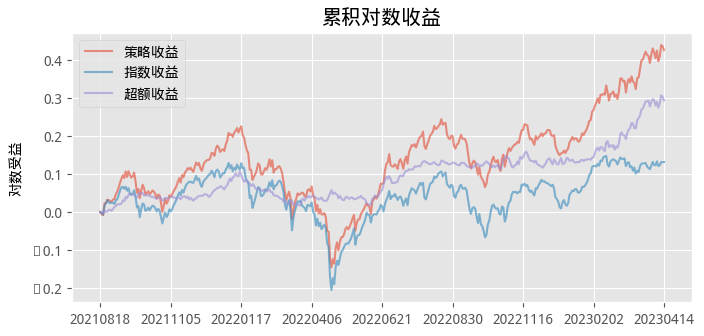

,指数收益,超额收益,策略收益
年化收益率,0.082,0.183,0.266
年化波动率,0.212,0.098,0.230
夏普率,0.388,1.874,1.158
最大回撤,-0.335,-0.090,-0.371
收益回撤比,0.245,2.033,0.717
胜率,0.554,0.534,0.584
盈亏比,0.857,1.198,0.856


In [365]:
h = ff.run(primal_panic_new.shift(1,axis=1).loc[:,'20210818':'20230414'], positions = 100, period = 1, fees = 0) 

# 3、草木皆兵因子
## 3—1、波动率加剧
1) 取股票 1 分钟频率的行情数据, 计算每分钟收盘价相对上一分钟收盘价的涨跌幅, 将全天每分钟收益率求标准差, 得到这一天该个股TIES
的波动率。
2）计算每天每只股票的收益率和 “惊恐度”。
3) 将每天的波动率、“惊恐度” 和收益率相乘, 作为当日的加权决策分。
4）每月月底, 分别计算过去 20 日的加权决策分的均值和标准差, 记为 “波动率加剧-惊恐收益” 因子和 “波动率加剧-惊恐波动” 因子,并将二者等权合成为“波动率加剧-惊恐”因子。

In [366]:
def get_volatility(code):
    result={}
    try:
        data=ff.read_min(code)['close']
        data.index=pd.to_datetime(data.index)
        data=data.groupby(data.index.date).apply(lambda x:((x-x.shift(1))/x.shift(1)).std())
        # index转换
        data_date=data.index
        data.index=pd.to_datetime(data_date).strftime('%Y%m%d')
        result[code]=data
    except:
        result[code]=np.nan
    return result


In [367]:
with Pool(24) as p:
    res_lst_volatility = list(tqdm(p.imap(get_volatility, codes), total=len(codes)))
volatility=pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_volatility}).T

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5275/5275 [01:30<00:00, 58.30it/s]


In [368]:
def get_increased_volatility(code):
    result_1={}
    result_2={}
    result_3={}
    data=panic_degree.loc[code,:]*ret.loc[code,:]*volatility.loc[code,:]
    increased_volatility_panic_ret=(data.rolling(window=20, min_periods=1).mean())
    increased_volatility_panic_vol=(data.rolling(window=20, min_periods=1).std())
    result_1[code]=increased_volatility_panic_ret
    result_2[code]=increased_volatility_panic_vol
    result_3[code]=(increased_volatility_panic_ret+increased_volatility_panic_vol)/2
    return result_1,result_2,result_3

In [369]:
with Pool(24) as p:
    res_lst_get_increased_volatility = list(tqdm(p.imap(get_increased_volatility, codes), total=len(codes)))
res_lst_increased_volatility_panic_ret,res_lst_increased_volatility_panic_vol, res_lst_increased_volatility_panic = zip(*res_lst_get_increased_volatility)
increased_volatility_panic_ret=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_increased_volatility_panic_ret}).T)*ff.filter0).dropna(how='all',axis=1)
increased_volatility_panic_vol=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_increased_volatility_panic_vol}).T)*ff.filter0).dropna(how='all',axis=1)
increased_volatility_panic=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_increased_volatility_panic}).T)*ff.filter0).dropna(how='all',axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5275/5275 [00:04<00:00, 1203.05it/s]


In [ ]:
increased_volatility_panic_ret_new = extend.spread_reg(increased_volatility_panic_ret.loc[:,start:end],  mv.loc[:,start:end],ind=True) 
increased_volatility_panic_vol_new = extend.spread_reg(increased_volatility_panic_vol.loc[:,start:end],  mv.loc[:,start:end],ind=True) 
increased_volatility_panic_new = extend.spread_reg(increased_volatility_panic.loc[:,start:end],  mv.loc[:,start:end],ind=True) 

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


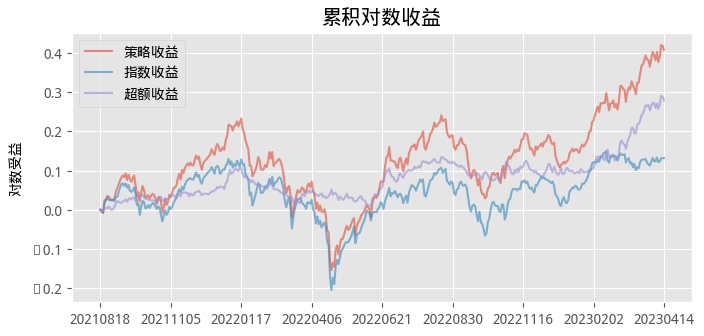

,指数收益,超额收益,策略收益
年化收益率,0.082,0.174,0.255
年化波动率,0.212,0.112,0.244
夏普率,0.388,1.550,1.041
最大回撤,-0.335,-0.104,-0.387
收益回撤比,0.245,1.675,0.658
胜率,0.554,0.491,0.584
盈亏比,0.857,1.333,0.840


In [222]:
h = ff.run(increased_volatility_panic_new.shift(1,axis=1).loc[:,'20210818':'20230414'], positions = 100, period = 1, fees = 0) 

## 3-2、个人投资者交易占比
1）参考 wind 资金流指标定义，我们将单笔成交金额小于 4 万元的交易, 视为个人投资者交易。我们计算每天个股个人投资者卖出和买入的金额均值，再除以个股的当日总体成交金额，得到当日个股的个人投资者交易比。
2）如上述计算每天的收益率和 “惊恐度” 。
3）将每天的个人投资者交易比、“惊恐度” 和收益率相乘, 作为当日的加权决策分。
4）每月月底, 分别计算过去 20 日的加权决策分的均值和标准差, 记为 “个人投资者交易比-惊恐收益” 因子和 “个人投资者交易比-惊恐波动” 因子，并将二者等权合成为 “个人投资者交易比-惊恐” 因子。

In [370]:
individual_trading_ratio=10*(read_data('buy_sm_amount')+read_data('sell_sm_amount'))/(read_data('amount')*2)

In [100]:
def get_individual_trading_ratio_panic(code):
    result_1={}
    result_2={}
    result_3={}
    data=panic_degree.loc[code,:]*ret.loc[code,:]*individual_trading_ratio.loc[code,:]
    individual_trading_ratio_panic_ret=(data.rolling(window=20, min_periods=1).mean())
    individual_trading_ratio_panic_vol=(data.rolling(window=20, min_periods=1).std())
    result_1[code]=individual_trading_ratio_panic_ret
    result_2[code]=individual_trading_ratio_panic_vol
    result_3[code]=(individual_trading_ratio_panic_ret+individual_trading_ratio_panic_vol)/2
    return result_1,result_2,result_3

In [101]:
with Pool(24) as p:
    res_lst_get_individual_trading_ratio_panic = list(tqdm(p.imap(get_individual_trading_ratio_panic, codes), total=len(codes)))
res_lst_individual_trading_ratio_panic_ret,res_lst_individual_trading_ratio_panic_vol, res_lst_individual_trading_ratio_panic = zip(*res_lst_get_individual_trading_ratio_panic)
individual_trading_ratio_panic_ret=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_individual_trading_ratio_panic_ret}).T)*ff.filter0).dropna(how='all',axis=1)
individual_trading_ratio_panic_vol=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_individual_trading_ratio_panic_vol}).T)*ff.filter0).dropna(how='all',axis=1)
individual_trading_ratio_panic=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_individual_trading_ratio_panic}).T)*ff.filter0).dropna(how='all',axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5275/5275 [00:05<00:00, 923.27it/s]


# 3-3、注意力衰减
1) 计算每天的 “惊恐度”, 将 $\mathrm{t}$ 日的惊恐度, 减去 $\mathrm{t}-1$ 日和 $\mathrm{t}-2$ 日的 “惊恐度” 的均值, 得到一个差值, 由于该差值需要作为权重信息来使用, 因此要保证指标为正数, 这里将该差值为负的交易日的数据都替换为空值, 仅保留将 $\mathrm{t}$ 日的惊恐度大于 $\mathrm{t}-1$ 日和 $\mathrm{t}-2$ 日的 “惊恐度”
2) 计算每天的收益率。
3) 将每天的衰减后的 “惊恐度” 和收益率相乘, 作为当日的加权决策分。
4）每月月底, 分别计算过去 20 日的加权决策分的均值和标准差（由于上述差值为负的日子都替换为了空值, 导致衰减后的 “惊恐度” 復盖度较低, 因此本处为了提高最终因子覆盖率, 只要每月加权决策分数据足够 5 条, 就可以计算, 下同), 记为 “注意力衰减-惊恐收益”因子和 “注意力衰减-惊恐波动” 因子, 并将二者等权合成为“注意力衰减-惊恐”因子。

In [371]:
attenuated_panic_degree=panic_degree-(panic_degree.shift(1,axis=1)+panic_degree.shift(2,axis=1))/2
# 将小于0的值替换为空值
attenuated_panic_degree[attenuated_panic_degree< 0]=np.nan

In [104]:
def get_attenuated_panic(code):
    result_1={}
    result_2={}
    result_3={}
    data=ret.loc[code,:]*attenuated_panic_degree.loc[code,:]
    attenuated_panic_ret=(data.rolling(window=20, min_periods=5).mean())
    attenuated_panic_vol=(data.rolling(window=20, min_periods=5).std())
    result_1[code]=attenuated_panic_ret
    result_2[code]=attenuated_panic_vol
    result_3[code]=(attenuated_panic_ret+attenuated_panic_vol)/2
    return result_1,result_2,result_3    

In [105]:
with Pool(24) as p:
    res_lst_get_attenuated_panic = list(tqdm(p.imap(get_attenuated_panic, codes), total=len(codes)))
res_lst_attenuated_panic_ret,res_lst_attenuated_panic_vol, res_lst_attenuated_panic = zip(*res_lst_get_attenuated_panic)
attenuated_panic_ret=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_attenuated_panic_ret}).T)*ff.filter0).dropna(how='all',axis=1)
attenuated_panic_vol=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_attenuated_panic_vol}).T)*ff.filter0).dropna(how='all',axis=1)
attenuated_panic=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_attenuated_panic}).T)*ff.filter0).dropna(how='all',axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5275/5275 [01:42<00:00, 51.28it/s]


## 3-4、草木皆兵因子
1）如上述, 分别计算每天个股的波动率、个人投资者交易比、衰减后的 “惊恐度” 、收益率。

2) 将每天的衰减后的 “惊恐度” 、波动率、个人投资者者交易比、收益率相乘, 作为当日的加权决策分。
每月月底, 分别计算过去 20 日的加权决策分的均值和标准差, 记为 “草木皆兵-收益” 因子和 “草木皆兵-波动” 因子, 并将二者等权合成为“草木皆兵” 因子。

In [460]:
def get_extreme_nervous(code):
    result_1={}
    result_2={}
    result_3={}
    data=ret.loc[code,:]*attenuated_panic_degree.loc[code,:]*volatility.loc[code,:]*individual_trading_ratio.loc[code,:]
    extreme_nervous_ret=(data.rolling(window=20, min_periods=5).mean())
    extreme_nervous_vol=(data.rolling(window=20, min_periods=5).std())
    result_1[code]=extreme_nervous_ret
    result_2[code]=extreme_nervous_vol
    result_3[code]=(extreme_nervous_ret+extreme_nervous_vol)/2
    return result_1,result_2,result_3    

In [461]:
with Pool(24) as p:
    res_lst_get_extreme_nervous = list(tqdm(p.imap(get_extreme_nervous, codes), total=len(codes)))
res_lst_extreme_nervous_ret,res_lst_extreme_nervous_vol, res_lst_extreme_nervous = zip(*res_lst_get_extreme_nervous)
extreme_nervous_ret=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_extreme_nervous_ret}).T)*ff.filter0).dropna(how='all',axis=1)
extreme_nervous_vol=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_extreme_nervous_vol}).T)*ff.filter0).dropna(how='all',axis=1)
extreme_nervous=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_extreme_nervous}).T)*ff.filter0).dropna(how='all',axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5275/5275 [00:03<00:00, 1405.09it/s]


In [450]:
# 进行市值和行业正交化处理
# 由于行业中性化的时间限制，我们选取'20170103'之后的时间
extreme_nervous_ret_new = extend.spread_reg(extreme_nervous_ret.loc[:,start:end], mv.loc[:,start:end],ind=True) 
extreme_nervous_vol_new = extend.spread_reg(extreme_nervous_vol.loc[:,start:end], mv.loc[:,start:end],ind=True) 
extreme_nervous_new = extend.spread_reg(extreme_nervous.loc[:,start:end],mv.loc[:,start:end],ind=True) 

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0.0
交易模式： t日收盘价买入，收盘价卖出


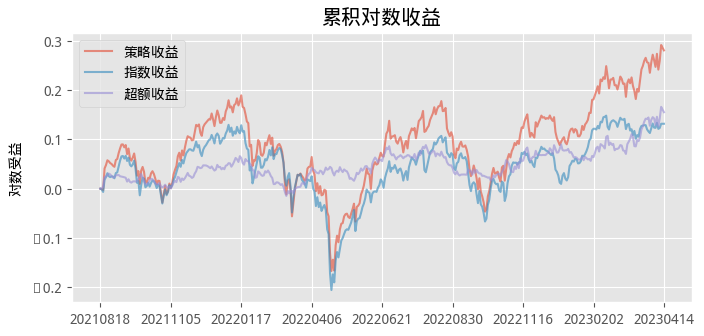

,指数收益,超额收益,策略收益
年化收益率,0.082,0.097,0.175
年化波动率,0.212,0.105,0.252
夏普率,0.388,0.924,0.694
最大回撤,-0.335,-0.080,-0.356
收益回撤比,0.245,1.201,0.491
胜率,0.554,0.474,0.569
盈亏比,0.857,1.290,0.846


In [451]:
h = ff.run(extreme_nervous_new.shift(1,axis=1).loc[:,'20210818':'20230414'], positions = 100, period = 1, fees = 0.00)# '20210818':'20230414'

In [150]:
# 读取
neutralized_CMJB = load('neutralized_CMJB_jun')

,20200113,20200114,20200115,20200116,20200117,20200120,20200121,20200122,20200123,20200203,...,20230331,20230403,20230404,20230406,20230407,20230410,20230411,20230412,20230413,20230414
000001.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.415256,-0.420440,-0.071676,...,-6.506003,-6.256929,-8.129339,-6.561561,-6.908416,-7.356181,-7.225736,-6.366905,-6.030688,-6.422012
000002.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-13.251157,-12.649128,-14.997510,-14.896533,-15.108640,-4.731595,-4.807526,-5.527820,-4.896734,-4.156891
000004.SZ,NaN,NaN,NaN,NaN,NaN,NaN,5.065576,-20.309951,-18.524623,-19.944025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000005.SZ,NaN,NaN,-3.520939,-5.258939,-6.367767,-9.65825,-10.251806,-9.120445,-9.767703,-10.000337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000006.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-16.524368,-15.828038,-15.221665,...,-0.027729,-3.792574,-5.034191,-5.813103,-5.644430,-8.535063,-13.238012,-13.623363,-13.482452,-12.926188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688799.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-15.393504,-16.175713,-14.709830,-15.297080,-17.581798,-23.863437,-24.326497,-24.743589,-24.886765,-26.835760
688800.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-37.571867,-35.925952,-36.734901,-36.492872,-36.710491,-34.776716,-33.157490,-27.674729,-28.853571,-27.183067
688819.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-20.678723,-20.798469,-18.408957,-17.819679,-18.170845,-19.683048,-23.708778,-23.439473,-24.726634,-24.076066
688981.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,71.443608,71.953608,81.501320,70.184536,65.752881,72.940196,72.927593,65.071308,9.348523,11.526523


## 3-7、周频下因子表现结果更加

In [409]:
def get_extreme_nervous_week(code):
    result_1={}
    result_2={}
    result_3={}
    data=ret.loc[code,:]*attenuated_panic_degree.loc[code,:]*volatility.loc[code,:]*individual_trading_ratio.loc[code,:]
    extreme_nervous_ret_week=(data.rolling(window=5, min_periods=4).mean())
    extreme_nervous_vol_week=(data.rolling(window=5, min_periods=4).std())
    result_1[code]=extreme_nervous_ret_week
    result_2[code]=extreme_nervous_vol_week
    result_3[code]=(extreme_nervous_ret_week+extreme_nervous_vol_week)/2
    return result_1,result_2,result_3    

In [410]:
with Pool(24) as p:
    res_lst_get_extreme_nervous_week = list(tqdm(p.imap(get_extreme_nervous_week, codes), total=len(codes)))
res_lst_extreme_nervous_ret_week,res_lst_extreme_nervous_vol_week, res_lst_extreme_nervous_week = zip(*res_lst_get_extreme_nervous_week)
extreme_nervous_ret_week=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_extreme_nervous_ret_week}).T)*ff.filter0).dropna(how='all',axis=1)
extreme_nervous_vol_week=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_extreme_nervous_vol_week}).T)*ff.filter0).dropna(how='all',axis=1)
extreme_nervous_week=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_extreme_nervous_week}).T)*ff.filter0).dropna(how='all',axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5275/5275 [00:05<00:00, 1042.88it/s]


In [406]:
# 进行市值和行业正交化处理
# 由于行业中性化的时间限制，我们选取'20170103'之后的时间
extreme_nervous_ret_week_new = extend.spread_reg(extreme_nervous_ret_week.loc[:,start:end], mv.loc[:,start:end],ind=True) 
extreme_nervous_vol_week_new = extend.spread_reg(extreme_nervous_vol_week.loc[:,start:end], mv.loc[:,start:end],ind=True) 
extreme_nervous_week_new = extend.spread_reg(extreme_nervous_week.loc[:,start:end], mv.loc[:,start:end],ind=True) 

In [411]:
extreme_nervous_week_new = extend.spread_reg(extreme_nervous_week.loc[:,start:end], mv.loc[:,start:end],ind=True) 

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


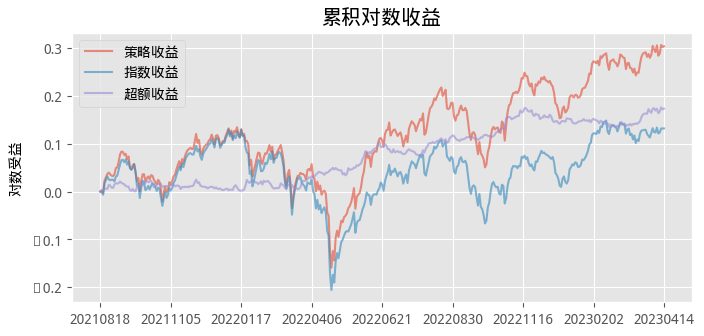

,指数收益,超额收益,策略收益
年化收益率,0.082,0.108,0.189
年化波动率,0.212,0.062,0.224
夏普率,0.388,1.747,0.841
最大回撤,-0.335,-0.039,-0.293
收益回撤比,0.245,2.733,0.645
胜率,0.554,0.531,0.581
盈亏比,0.857,1.186,0.826


In [412]:
h = ff.run(extreme_nervous_week_new.shift(1,axis=1).loc[:,'20210818':'20230414'], positions = 100, period = 1, fees = 0) # '20210818':'20230414'

In [473]:
mv=read_data("total_mv")

In [475]:
def read_data(keyword):
    if keyword in ('open', 'close', 'high', 'low'):
        return (ff.read(keyword) * ff.read('post') * ff.filter0).loc[:, start:end] 
    else:
        (ff.read(keyword) * ff.filter0).loc[:, start:end]

In [478]:
keyword='total_mv'
'close' in ('open', 'close', 'high', 'low')

True

In [ ]:
# 中性化函数的探究
# 1、时间的影响:经过数值对比以及回测对比，时间没有影响；ps:在回测时，第一天是否有数据的影响比较大，0.02
# 2、空值股票的影响：经过数值对比以及回测对比，空值股票没有影响，两者股票数目不一致也没有关系,中性化后的股票数是已经删除过空值股票的了,同时也删除过空值时间 
# 3、时间不一致的影响：因子时间缺失没有影响，mv时间缺失会报错

In [479]:
# %load neverse_create.py
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
from tqdm import tqdm
import pandas as pd
import numpy as np
import datetime
from IPython.display import display
import tushare as ts
from multiprocessing import Pool
from tqdm import tqdm
pro = ts.pro_api('5b6a2c5b17b9572fe089a0802765f8b6434e72c51572718b1d37c302')

start, end = '20200101', '20240201'
zz_total = pro.index_daily(ts_code='000985.SH', start_date='2020-01-01')    
zz_total_ret=zz_total['close'].pct_change(-1)
zz_total_ret.index=zz_total['trade_date']
zz_total_ret=zz_total_ret.loc[zz_total_ret.index.isin(ff.idt)]


def read_data(keyword):
    if keyword in ('open', 'close', 'high', 'low'):
        return (ff.read(keyword) * ff.read('post') * ff.filter0).loc[:, start:end] 
    else:
        return (ff.read(keyword) * ff.filter0).loc[:, start:end]
        
close=read_data('close')
ret=(close-close.shift(1,axis=1))/close.shift(1,axis=1)

# 惊恐度
def get_panic_degree(code):
    result={}
    result[code]= abs(ret.loc[code,:]-zz_total_ret)/(abs(ret.loc[code,:])+abs(zz_total_ret)+0.1)
    return result

with Pool(24) as p:
    res_lst_panic_degree = list(tqdm(p.imap(get_panic_degree, codes), total=len(codes)))
panic_degree=pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_panic_degree}).T  

def get_primal_panic(code):
    result_1={}
    result_2={}
    result_3={}
    data=panic_degree.loc[code,:]*ret.loc[code,:]
    factor_ret=(data.rolling(window=20, min_periods=20).mean())
    factor_vol=(data.rolling(window=20, min_periods=20).std())
    result_1[code]=factor_ret
    result_2[code]=factor_vol
    result_3[code]=(factor_ret+factor_vol)*0.5
    return result_1,result_2,result_3


def get_volatility(code):
    result={}
    try:
        data=ff.read_min(code)['close']
        data.index=pd.to_datetime(data.index)
        data=data.groupby(data.index.date).apply(lambda x:((x-x.shift(1))/x.shift(1)).std())
        # index转换
        data_date=data.index
        data.index=pd.to_datetime(data_date).strftime('%Y%m%d')
        result[code]=data
    except:
        result[code]=np.nan
    return result
with Pool(24) as p:
    res_lst_volatility = list(tqdm(p.imap(get_volatility, codes), total=len(codes)))
volatility=pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_volatility}).T
individual_trading_ratio=10*(read_data('buy_sm_amount')+read_data('sell_sm_amount'))/(read_data('amount')*2)
attenuated_panic_degree=panic_degree-(panic_degree.shift(1,axis=1)+panic_degree.shift(2,axis=1))/2
attenuated_panic_degree[attenuated_panic_degree< 0]=np.nan

def get_extreme_nervous(code):
    result_1={}
    result_2={}
    result_3={}
    data=ret.loc[code,:]*attenuated_panic_degree.loc[code,:]*volatility.loc[code,:]*individual_trading_ratio.loc[code,:]
    extreme_nervous_ret=(data.rolling(window=20, min_periods=5).mean())
    extreme_nervous_vol=(data.rolling(window=20, min_periods=5).std())
    result_1[code]=extreme_nervous_ret
    result_2[code]=extreme_nervous_vol
    result_3[code]=(extreme_nervous_ret+extreme_nervous_vol)*0.5
    return result_1,result_2,result_3    

def get_extreme_nervous_week(code):
    result_1={}
    result_2={}
    result_3={}
    data=ret.loc[code,:]*attenuated_panic_degree.loc[code,:]*volatility.loc[code,:]*individual_trading_ratio.loc[code,:]
    extreme_nervous_ret_week=(data.rolling(window=5, min_periods=4).mean())
    extreme_nervous_vol_week=(data.rolling(window=5, min_periods=4).std())
    result_1[code]=extreme_nervous_ret_week
    result_2[code]=extreme_nervous_vol_week
    result_3[code]=(extreme_nervous_ret_week+extreme_nervous_vol_week)*0.5
    return result_1,result_2,result_3    


def main():
    from multiprocessing import Pool,Manager
    from tqdm import tqdm

    codes=ff.cl
    mv=read_data("total_mv")
  
    with Pool(24) as p:
        res_lst_get_primal_panic = list(tqdm(p.imap(get_primal_panic, codes), total=len(codes)))
    res_lst_factor_ret,res_lst_factor_vol, res_lst_primal_panic = zip(*res_lst_get_primal_panic)
    factor_ret=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_factor_ret}).T)*ff.filter0).dropna(how='all',axis=1)
    factor_vol=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_factor_vol}).T)*ff.filter0).dropna(how='all',axis=1)
    primal_panic=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_primal_panic}).T)*ff.filter0).dropna(how='all',axis=1)
    factor_ret_new = extend.spread_reg(factor_ret.loc[:,start:end], mv.loc[:,start:end],ind=True) 
    factor_vol_new = extend.spread_reg(factor_vol.loc[:,start:end], mv.loc[:,start:end],ind=True) 
    primal_panic_new = extend.spread_reg(primal_panic.loc[:,start:end],mv.loc[:,start:end],ind=True) 
    ff.save('primal_panic_RC',primal_panic_new.shift(1,axis=1))

    with Pool(24) as p:
        res_lst_get_extreme_nervous = list(tqdm(p.imap(get_extreme_nervous, codes), total=len(codes)))
    res_lst_extreme_nervous_ret,res_lst_extreme_nervous_vol, res_lst_extreme_nervous = zip(*res_lst_get_extreme_nervous)
    extreme_nervous_ret=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_extreme_nervous_ret}).T)*ff.filter0).dropna(how='all',axis=1)
    extreme_nervous_vol=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_extreme_nervous_vol}).T)*ff.filter0).dropna(how='all',axis=1)
    extreme_nervous=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_extreme_nervous}).T)*ff.filter0).dropna(how='all',axis=1)
    extreme_nervous_ret_new = extend.spread_reg(extreme_nervous_ret.loc[:,start:end], mv.loc[:,start:end],ind=True) 
    extreme_nervous_vol_new = extend.spread_reg(extreme_nervous_vol.loc[:,start:end], mv.loc[:,start:end],ind=True) 
    extreme_nervous_new = extend.spread_reg(extreme_nervous.loc[:,start:end],mv.loc[:,start:end],ind=True)   
    ff.save('extreme_nervous_RC',extreme_nervous_new.shift(1,axis=1))

    
    with Pool(24) as p:
        res_lst_get_extreme_nervous_week = list(tqdm(p.imap(get_extreme_nervous_week, codes), total=len(codes)))
    res_lst_extreme_nervous_ret_week,res_lst_extreme_nervous_vol_week, res_lst_extreme_nervous_week = zip(*res_lst_get_extreme_nervous_week)
    extreme_nervous_ret_week=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_extreme_nervous_ret_week}).T)*ff.filter0).dropna(how='all',axis=1)
    extreme_nervous_vol_week=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_extreme_nervous_vol_week}).T)*ff.filter0).dropna(how='all',axis=1)
    extreme_nervous_week=((pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_extreme_nervous_week}).T)*ff.filter0).dropna(how='all',axis=1)
    extreme_nervous_ret_week_new = extend.spread_reg(extreme_nervous_ret_week.loc[:,start:end], mv.loc[:,start:end],ind=True) 
    extreme_nervous_vol_week_new = extend.spread_reg(extreme_nervous_vol_week.loc[:,start:end], mv.loc[:,start:end],ind=True) 
    extreme_nervous_week_new = extend.spread_reg(extreme_nervous_week.loc[:,start:end], mv.loc[:,start:end],ind=True) 
    ff.save('extreme_nervous_week_RC',extreme_nervous_week_new.shift(1,axis=1))
    
if __name__ == '__main__':
    main()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5275/5275 [00:05<00:00, 1027.16it/s]
